In [4]:
import sys
from pathlib import Path
from datetime import timedelta
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import os
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

import numpy as np
from scipy.integrate import simpson
from numpy import trapz

In [5]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [6]:
TRAIN_DATASET = sorted([x for x in Path("data/trainlight/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("data/test/").glob("*.csv")])

TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)
print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(100440, 88)


,timestamp,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_HT_PS,P4_LD,P4_ST_FD,P4_ST_GOV,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,Attack
0,2021-07-11 13:03:57,0.14866,1.26643,479.36264,989.099,26.92264,9.26430,249.46480,31.14853,11.66788,...,7.08818,423.01434,0.00109,20843,415.05713,381.94440,2.5498,9999,27150,0
1,2021-07-11 13:03:58,0.14866,1.27272,479.36264,989.099,26.92264,9.32287,245.49232,31.16951,11.69643,...,7.08818,423.32178,0.00282,21013,415.99756,385.19965,2.5498,9999,27146,0
2,2021-07-11 13:03:59,0.14866,1.28199,479.36264,989.099,26.92264,9.39396,248.47186,31.20041,11.73156,...,7.08818,424.93127,0.00152,21134,419.68677,387.76770,2.5498,9999,27146,0
3,2021-07-11 13:04:00,0.14866,1.29161,479.36264,989.099,26.92264,9.39396,249.46480,31.23246,11.75354,...,7.08818,424.51532,0.00231,21294,418.34857,390.48035,2.5498,9999,27152,0
4,2021-07-11 13:04:01,0.14866,1.29779,479.36264,989.099,26.92264,9.46934,250.45811,31.25306,11.88941,...,7.08818,417.29962,0.00586,21216,411.29559,389.84735,2.5498,9999,27148,0


In [7]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "Attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD, ATTACK_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005', 'P1_B4002', 'P1_B4005',
       'P1_B400B', 'P1_B4022', 'P1_FCV01D', 'P1_FCV01Z', 'P1_FCV02D',
       'P1_FCV02Z', 'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT02',
       'P1_FT02Z', 'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z', 'P1_LIT01',
       'P1_PCV01D', 'P1_PCV01Z', 'P1_PCV02D', 'P1_PCV02Z', 'P1_PIT01',
       'P1_PIT01_HH', 'P1_PIT02', 'P1_PP01AD', 'P1_PP01AR', 'P1_PP01BD',
       'P1_PP01BR', 'P1_PP02D', 'P1_PP02R', 'P1_PP04', 'P1_PP04SP',
       'P1_SOL01D', 'P1_SOL03D', 'P1_STSP', 'P1_TIT01', 'P1_TIT02', 'P1_TIT03',
       'P2_24Vdc', 'P2_ATSW_Lamp', 'P2_AutoGO', 'P2_AutoSD', 'P2_Emerg',
       'P2_MASW', 'P2_MASW_Lamp', 'P2_ManualGO', 'P2_ManualSD', 'P2_OnOff',
       'P2_RTR', 'P2_SCO', 'P2_SCST', 'P2_SIT01', 'P2_TripEx', 'P2_VIBTR01',
       'P2_VIBTR02', 'P2_VIBTR03', 'P2_VIBTR04', 'P2_VT01', 'P2_VTR01',
       'P2_VTR02', 'P2_VTR03', 'P2_VTR04', 'P3_FIT01', 'P3_LCP01D',
       'P3_LCV01D', 'P3_LH01', 'P

In [8]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [9]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [10]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,P1_FCV01Z,...,P4_HT_PO,P4_HT_PS,P4_LD,P4_ST_FD,P4_ST_GOV,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01
0,0.649023,0.656212,0.832023,0.320017,0.183119,0.092643,0.074688,0.290664,0.109050,0.105271,...,0.270230,0.708818,0.713497,0.610766,0.607969,0.722891,0.605875,0.145186,0.464986,0.407407
1,0.649023,0.663857,0.832023,0.320017,0.183119,0.093175,0.073551,0.292645,0.109312,0.105271,...,0.251065,0.708818,0.714550,0.692170,0.619879,0.726277,0.618202,0.145186,0.464986,0.401552
2,0.649023,0.675710,0.832023,0.320017,0.183119,0.093864,0.074294,0.295715,0.109654,0.105271,...,0.227660,0.708818,0.720108,0.638884,0.629352,0.739745,0.628950,0.145186,0.464986,0.401024
3,0.649023,0.688460,0.832023,0.320017,0.183119,0.093932,0.074648,0.299016,0.109888,0.105271,...,0.209434,0.708818,0.719248,0.670413,0.641389,0.736308,0.640184,0.145186,0.464986,0.409669
4,0.649023,0.697170,0.832023,0.320017,0.183119,0.094617,0.074965,0.301271,0.111145,0.105271,...,0.193430,0.708818,0.694695,0.838937,0.637181,0.710824,0.638934,0.145186,0.464986,0.404735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100435,0.098725,0.294744,0.402313,0.157748,0.815664,1.000000,0.996679,0.751969,1.000000,0.999772,...,0.303524,0.656132,0.288864,0.528125,0.304060,0.273526,0.303039,0.282591,0.310924,0.655692
100436,0.098725,0.293017,0.402313,0.157748,0.815664,1.000000,0.996762,0.751524,1.000000,0.999840,...,0.278543,0.656132,0.272880,0.696601,0.294732,0.261796,0.297084,0.282591,0.310924,0.651076
100437,0.098725,0.287754,0.402313,0.157748,0.815664,1.000000,0.998578,0.750160,1.000000,0.999847,...,0.253621,0.656132,0.265089,0.669660,0.287419,0.255466,0.290861,0.282591,0.310924,0.654963
100438,0.098725,0.281585,0.402313,0.157748,0.815664,1.000000,0.998759,0.748561,1.000000,0.999848,...,0.232921,0.656132,0.255602,0.572401,0.288907,0.250837,0.288815,0.282591,0.310924,0.656801


In [11]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [12]:
boundary_check(TRAIN_DF)

(False, False, False)

In [13]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"Attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        
        return item

In [14]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
HAI_DATASET_TRAIN[0]

  0%|          | 0/100351 [00:00<?, ?it/s]

# of valid windows: 99906


{'ts': '2021-07-11 13:05:26',
 'given': tensor([[0.6490, 0.6562, 0.8320,  ..., 0.1452, 0.4650, 0.4074],
         [0.6490, 0.6639, 0.8320,  ..., 0.1452, 0.4650, 0.4016],
         [0.6490, 0.6757, 0.8320,  ..., 0.1452, 0.4650, 0.4010],
         ...,
         [0.6490, 0.4784, 0.8320,  ..., 0.1452, 0.3922, 0.4330],
         [0.6490, 0.4731, 0.8320,  ..., 0.1452, 0.3922, 0.4288],
         [0.6490, 0.4822, 0.8320,  ..., 0.1452, 0.3922, 0.4255]]),
 'answer': tensor([6.4902e-01, 4.8637e-01, 8.3202e-01, 3.2002e-01, 1.8312e-01, 7.0673e-02,
         7.4372e-02, 2.4668e-01, 1.0558e-01, 1.0550e-01, 1.0000e+00, 9.9731e-01,
         2.3875e-01, 3.2639e-01, 2.8372e-01, 3.2186e-01, 1.7395e-02, 7.2041e-02,
         4.2029e-01, 4.7572e-01, 3.3692e-01, 3.3315e-01, 6.4113e-01, 3.1599e-01,
         2.8492e-01, 0.0000e+00, 5.0000e-01, 3.9132e-01, 0.0000e+00, 4.8964e-03,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.8044e-01, 0.0000e+00, 0.0000e+00, 0.

In [15]:
print(HAI_DATASET_TRAIN[0]['given'].shape)
print(HAI_DATASET_TRAIN[0]['answer'].shape)

torch.Size([89, 86])
torch.Size([86])


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn


class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=86):
        super(PositionalEncoding, self).__init__()

        # Not a parameter
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):
        ''' Sinusoid position encoding table '''
        # TODO: make it with torch instead of numpy

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)

        return enc_output, enc_slf_attn


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
                 self, 
                 n_src_vocab, 
                 d_word_vec, 
                 n_layers, 
                 n_head, 
                 d_k, 
                 d_v,
                 d_model, 
                 d_inner, 
                 dropout=0.1, 
                 n_position=89, 
                 scale_emb=False,
                 ):

        super().__init__()

        self.src_emb = nn.Linear(in_features=n_src_vocab, out_features=d_word_vec)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, return_attns=False):

        enc_slf_attn_list = []

        # -- Forward
        enc_output = self.src_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []

        if return_attns:
            return enc_output, enc_slf_attn_list

        return enc_output


class Transformer_encoder_model(nn.Module):

    def __init__(
                 self, 
                 n_src_vocab, 
                 d_word_vec, 
                 n_layers, 
                 n_head, 
                 d_k, 
                 d_v,
                 d_model, 
                 d_inner, 
                 ):
        super().__init__()
        self.encoder = Encoder(
                                n_src_vocab, 
                                d_word_vec, 
                                n_layers, 
                                n_head, 
                                d_k, 
                                d_v,
                                d_model, 
                                d_inner
                               )
        self.fc1 = nn.Linear(in_features=89 * 128, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=86)
    
    def forward(self, encoder_input, return_attns=False):
        output = self.encoder(encoder_input)
        output = self.fc1(output.view(output.size(0),-1))
        output = self.fc2(output)

        return output

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3
epochs = 10
model = Transformer_encoder_model(
                                  n_src_vocab = HAI_DATASET_TRAIN[0]['given'].shape[-1], 
                                  d_word_vec = 128, 
                                  n_layers = 3, 
                                  n_head = 4, 
                                  d_k = 32, 
                                  d_v = 32,
                                  d_model = 128, 
                                  d_inner = 256, 
                                  ).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
dataloader = DataLoader(HAI_DATASET_TRAIN, batch_size=512, shuffle=True)

In [18]:
from tqdm import tqdm

loss_list = []

for epoch in tqdm(range(1, epochs+1)):
    total_loss = 0
    n =0
    f1_scores = []

    for data in dataloader:
        input_data = data['given']
        target = data['answer']
        model.train()
        optimizer.zero_grad()
        pred = model(input_data.to(device))
        loss = loss_function(pred, target.to(device))
        loss.backward()
        optimizer.step()
        total_loss += (loss*input_data.size()[0])
        n += input_data.size()[0]

    loss_list.append(total_loss/n)

    print('epoch: {}, Train MSE_loss : {:.5f}'.format(epoch, total_loss/n))

 10%|█         | 1/10 [00:09<01:25,  9.52s/it]

epoch: 1, Train MSE_loss : 0.84706


 20%|██        | 2/10 [00:17<01:06,  8.37s/it]

epoch: 2, Train MSE_loss : 0.01491


 30%|███       | 3/10 [00:24<00:56,  8.02s/it]

epoch: 3, Train MSE_loss : 0.01412


 40%|████      | 4/10 [00:32<00:47,  7.87s/it]

epoch: 4, Train MSE_loss : 0.01478


 50%|█████     | 5/10 [00:39<00:38,  7.73s/it]

epoch: 5, Train MSE_loss : 0.01388


 60%|██████    | 6/10 [00:47<00:30,  7.66s/it]

epoch: 6, Train MSE_loss : 0.01162


 70%|███████   | 7/10 [00:54<00:22,  7.63s/it]

epoch: 7, Train MSE_loss : 0.00995


 80%|████████  | 8/10 [01:02<00:15,  7.58s/it]

epoch: 8, Train MSE_loss : 0.00904


 90%|█████████ | 9/10 [01:09<00:07,  7.56s/it]

epoch: 9, Train MSE_loss : 0.00780


100%|██████████| 10/10 [01:17<00:00,  7.75s/it]

epoch: 10, Train MSE_loss : 0.00831


In [19]:
# 모델 저장
torch.save(model.state_dict(), 'transfomer_encoder_10')

In [20]:
# 모델 생성
model = Transformer_encoder_model(
                                  n_src_vocab = HAI_DATASET_TRAIN[0]['given'].shape[-1], 
                                  d_word_vec = 128, 
                                  n_layers = 3, 
                                  n_head = 4, 
                                  d_k = 32, 
                                  d_v = 32,
                                  d_model = 128, 
                                  d_inner = 256, 
                                  ).to(device)

# 저장된 model 불러오기
with open('transfomer_encoder_10', "rb") as f:
     saved_state_dict = torch.load(f)
model.load_state_dict(saved_state_dict)

<All keys matched successfully>

In [21]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_HT_PS,P4_LD,P4_ST_FD,P4_ST_GOV,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,Attack
0,2021-07-10 00:00:01,0.059445,1.04366,431.328095,1034.712769,27.736847,14.91310,386.51172,31.52100,15.09755,...,0.716042,356.64423,0.00058,18131,292.86029,334.58112,20.989594,10000,27181,0
1,2021-07-10 00:00:02,0.059445,1.04217,431.328095,1034.712769,27.736847,14.95540,411.33905,31.51756,14.71477,...,0.716042,352.08698,-0.00282,18111,295.82605,332.97162,20.989594,9999,27174,0
2,2021-07-10 00:00:03,0.059445,1.03920,431.328095,1034.712769,27.736847,14.99200,438.15259,31.50269,14.30731,...,0.716042,347.63818,-0.00398,18100,300.02173,332.15784,20.989594,9999,27172,0
3,2021-07-10 00:00:04,0.059445,1.03222,431.328095,1034.712769,27.736847,15.01359,465.95908,31.47942,14.54943,...,0.716042,340.33203,-0.00152,18000,302.10144,330.96429,20.989594,9999,27168,0
4,2021-07-10 00:00:05,0.059445,1.02947,431.328095,1034.712769,27.736847,15.04767,452.05582,31.47942,15.24461,...,0.716042,335.17798,0.00072,17852,305.03113,329.02917,20.989594,9999,27172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,0.069440,1.04908,467.038540,1015.069640,25.687170,29.89865,1056.03259,29.45263,14.31306,...,2.403980,373.20966,0.00036,17966,318.08813,327.31122,26.760940,9917,26971,0
129596,2021-07-16 23:59:57,0.069440,1.05057,467.038540,1015.069640,25.687170,29.95392,1026.05530,29.45758,15.02294,...,2.403980,376.66376,-0.00470,18073,317.78070,327.36548,26.760940,9917,26970,0
129597,2021-07-16 23:59:58,0.069440,1.04839,467.038540,1015.069640,25.687170,29.99687,981.37659,29.45034,16.00788,...,2.403980,377.76691,-0.00130,17983,319.11890,326.62396,26.760940,9916,26973,0
129598,2021-07-16 23:59:59,0.069440,1.04255,467.038540,1015.069640,25.687170,30.02627,919.62439,29.43088,16.76628,...,2.403980,378.99664,0.00087,17956,316.78607,326.47931,26.760940,9916,26975,0


In [22]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,P1_FCV01Z,...,P4_HT_PO,P4_HT_PS,P4_LD,P4_ST_FD,P4_ST_GOV,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01
0,0.030932,0.358387,0.368375,0.905991,0.284554,0.149131,0.117813,0.329355,0.143643,0.159350,...,0.844123,0.071604,0.463446,0.584369,0.398967,0.238935,0.408587,1.195152,0.467787,0.457327
1,0.030932,0.356576,0.368375,0.905991,0.284554,0.149516,0.124915,0.329030,0.140133,0.156036,...,0.871032,0.071604,0.447837,0.424384,0.397566,0.249613,0.402493,1.195152,0.465241,0.447079
2,0.030932,0.352836,0.368375,0.905991,0.284554,0.149880,0.133157,0.327609,0.136114,0.145336,...,0.833744,0.071604,0.431331,0.355879,0.396676,0.265545,0.398890,1.195152,0.465011,0.443255
3,0.030932,0.344066,0.368375,0.905991,0.284554,0.150110,0.141848,0.325293,0.137914,0.143662,...,0.712366,0.071604,0.404921,0.463704,0.389652,0.274536,0.394058,1.195152,0.464989,0.437078
4,0.030932,0.339881,0.368375,0.905991,0.284554,0.150440,0.138779,0.325061,0.144405,0.144041,...,0.677241,0.071604,0.384806,0.578825,0.378685,0.285877,0.386321,1.195152,0.464986,0.442259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.100180,0.366195,0.713066,0.653647,0.029202,0.298944,0.327434,0.114644,0.135318,0.147118,...,0.429510,0.240398,0.526269,0.574387,0.386992,0.339343,0.378930,1.523774,0.236640,0.119731
129596,0.100180,0.367482,0.713066,0.653647,0.029202,0.299480,0.319899,0.114976,0.142133,0.135022,...,0.453088,0.240398,0.537610,0.337408,0.393747,0.337802,0.378571,1.523774,0.235429,0.117770
129597,0.100180,0.364988,0.713066,0.653647,0.029202,0.299920,0.306492,0.114332,0.151756,0.132923,...,0.474611,0.240398,0.542485,0.472095,0.388180,0.342418,0.375755,1.523774,0.232787,0.121922
129598,0.100180,0.357712,0.713066,0.653647,0.029202,0.300228,0.287662,0.112449,0.159602,0.132577,...,0.499186,0.240398,0.547142,0.586650,0.385751,0.334564,0.374931,1.523774,0.232522,0.125236


In [23]:
boundary_check(TEST_DF)

(True, True, False)

In [24]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_TEST[0]

  0%|          | 0/361111 [00:00<?, ?it/s]

# of valid windows: 360844


{'ts': '2021-07-10 00:01:30',
 'given': tensor([[0.0309, 0.3584, 0.3684,  ..., 1.1952, 0.4678, 0.4573],
         [0.0309, 0.3566, 0.3684,  ..., 1.1952, 0.4652, 0.4471],
         [0.0309, 0.3528, 0.3684,  ..., 1.1952, 0.4650, 0.4433],
         ...,
         [0.0309, 0.4334, 0.3684,  ..., 1.1952, 0.2275, 0.4967],
         [0.0309, 0.4280, 0.3684,  ..., 1.1952, 0.2320, 0.5018],
         [0.0309, 0.4239, 0.3684,  ..., 1.1952, 0.2274, 0.5024]]),
 'answer': tensor([ 3.0932e-02,  4.1643e-01,  3.6838e-01,  9.0599e-01,  2.8455e-01,
          1.5707e-01,  1.8097e-01,  3.4596e-01,  1.2004e-01,  1.4859e-01,
          9.9918e-01,  3.6355e-01,  7.6211e-01,  6.6304e-01,  3.3453e-01,
          3.8477e-01,  4.7029e-02,  1.9478e-01,  7.0710e-01,  7.5192e-01,
          5.2704e-01,  5.1666e-01,  2.5579e-01,  2.8349e-01,  2.5314e-01,
          0.0000e+00, -4.3939e-01,  2.5697e-01,  0.0000e+00,  2.1578e-01,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.00

In [25]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["Attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [26]:
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, model, batch_size=512)

In [27]:
def range_check(series, size):
    data = []
    
    for idx in range(size-1):
        data.append(series[idx])

    for i in range(size, len(series)+1):
        if i == size :
            check_std = np.std(series[i-size:i])
        std = np.std(series[i-size:i])
        mean = np.mean(series[i-size:i])
        max = np.max(series[i-size:i])
        check_std
        if check_std * 2 >= std:
            check_std = std
            data.append(mean)
        elif max == series[i]:
            data.append(max*5)
            check_std = std
        else:
            data.append(series[i]*3)
    #for _ in range(size-1):
    #    data.append(mean)

    return np.array(data)

In [28]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
C_ANOMALY_SCORE = range_check(ANOMALY_SCORE, size=30)
print(C_ANOMALY_SCORE.shape)

(360844,)


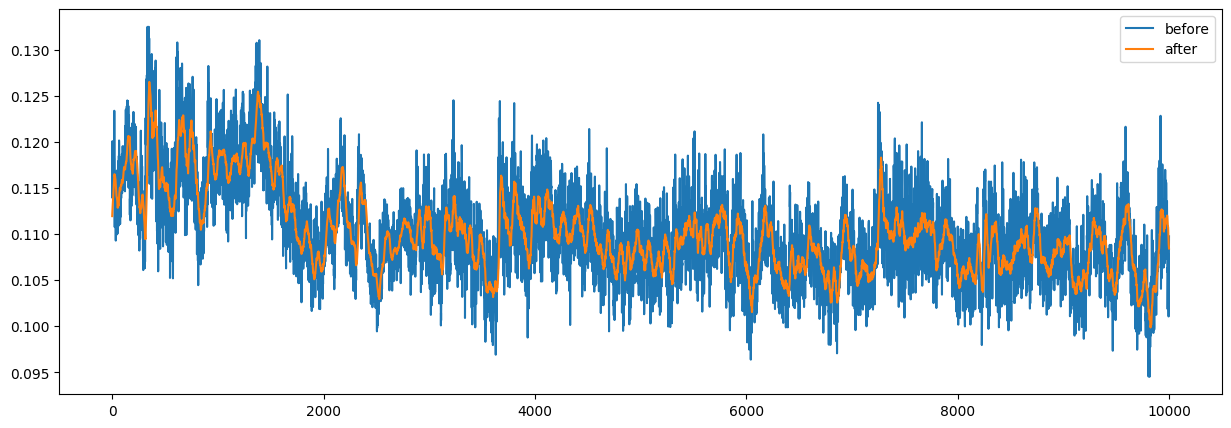

In [29]:
plt.figure(figsize=(15,5))
plt.plot(ANOMALY_SCORE[10000:20000], label='before')
plt.plot(C_ANOMALY_SCORE[10000:20000], label='after')
plt.legend()
plt.show()

In [30]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = np.max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

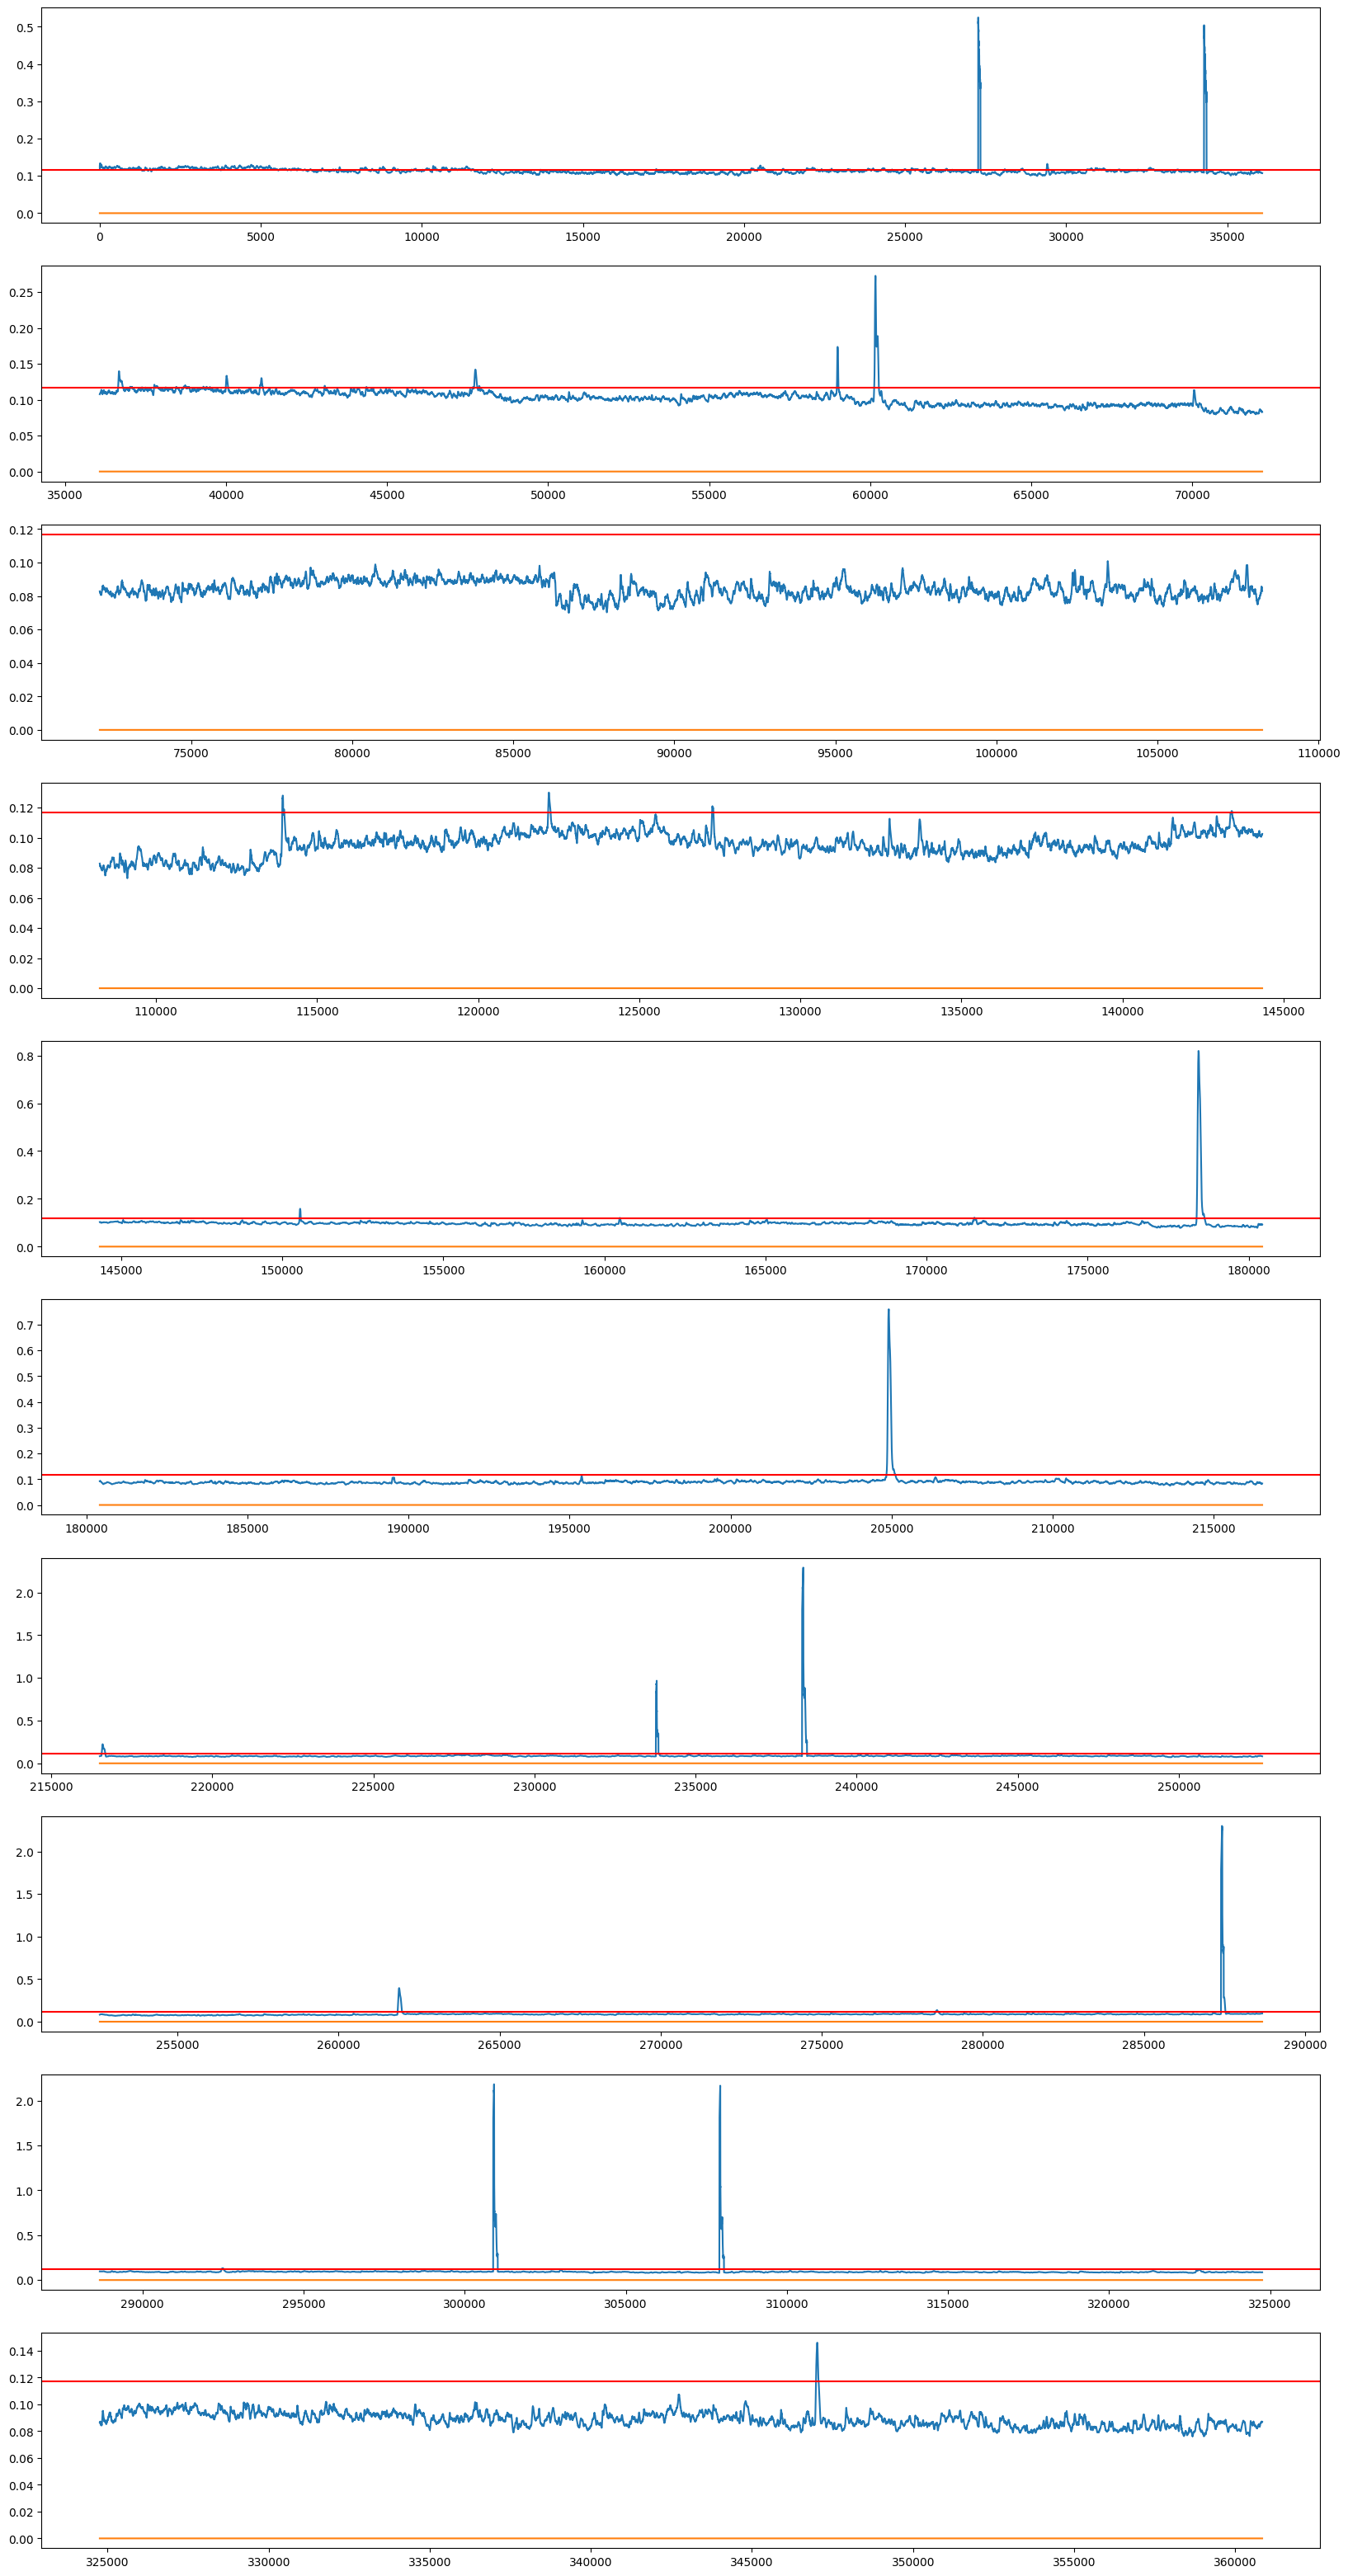

In [35]:
THRESHOLD = 0.117
check_graph(C_ANOMALY_SCORE, CHECK_ATT, piece=10, THRESHOLD=THRESHOLD)

In [36]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [37]:
LABELS = put_labels(C_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([1., 1., 1., ..., 0., 0., 0.]), (360844,))

In [38]:
ATTACK_LABELS = put_labels(np.array(TEST_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), (361200,))

In [39]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [40]:
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(TEST_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

(361200,)

In [41]:
def area_under_curve(x, y):
    n = len(x)
    area = 0.0
    for i in range(1, n):
        dx = x[i] - x[i-1]
        area += 0.5 * (y[i] + y[i-1]) * dx
    return area

In [42]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

training:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/361111 [00:00<?, ?it/s]

# of valid windows: 360844


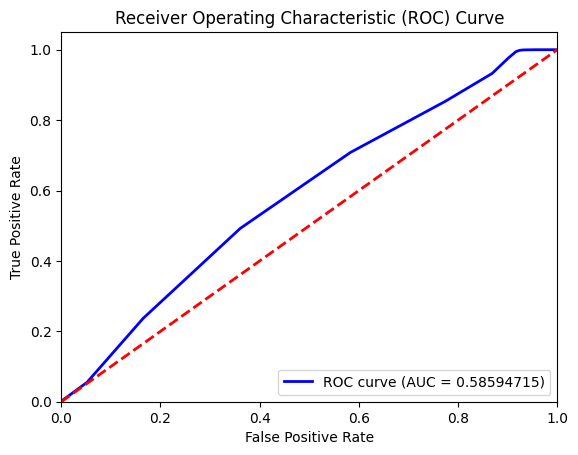

AUC Score: 0.5859471547906114


In [43]:
#Model
model.cuda()

#학습
model.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, model, batch_size = 512, n_epochs = 1)

#제일 좋은 모델 저장
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

#제일 좋은 모델 열기
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

model.load_state_dict(SAVED_MODEL["state"])


HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=TEST_DF_RAW[ATTACK_FIELD]
)

min = ANOMALY_SCORE.min()
max = ANOMALY_SCORE.max()
threshold_list = []
fpr_list = []
tpr_list = []
tp_list = []
tn_list = []
fp_list = []
fn_list = []
for i in range(0, 100):
    interval = (max - min)/100
    threshold_list.append(min + (i * interval)) 
        
    model.eval()
    CHECK_TS_TEST, CHECK_DIST_TEST, CHECK_ATT_TEST = inference(HAI_DATASET_TEST, model, batch_size = 512)
    ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
    ANOMALY_SCORE_TEST = np.mean(CHECK_DIST_TEST, axis=1)
    #check_graph(ANOMALY_SCORE_TEST, CHECK_ATT_TEST, piece=2, THRESHOLD=threshold_list[i])

    LABELS = put_labels(ANOMALY_SCORE, threshold_list[i])
    LABELS_TEST = put_labels(ANOMALY_SCORE_TEST, threshold_list[i])
    ATTACK_LABELS_TEST = put_labels(np.array(TEST_DF_RAW[ATTACK_FIELD]), threshold=threshold_list[i])

    FINAL_LABELS_TEST = fill_blank(CHECK_TS_TEST, LABELS_TEST, np.array(TEST_DF_RAW[TIMESTAMP_FIELD]))

    tp_test = 0
    tn_test = 0
    fp_test = 0
    fn_test = 0

    for i in range(0, len(FINAL_LABELS_TEST)):
        if ATTACK_LABELS_TEST[i] == 0:
            if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
                tp_test += 1
            else:
                fn_test += 1
        else:
            if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
                tn_test += 1
            else:
                fp_test += 1
        
    #append the metrics to the respective lists
    tp_list.append(tp_test)
    tn_list.append(tn_test)
    fp_list.append(fp_test)
    fn_list.append(fn_test)

    #accuracy = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test)
    #precision = tp_test / (tp_test + fp_test)
    #recall = tp_test / (tp_test + fn_test)
    #f1_score = 2 * precision * recall / (precision + recall)
    
    tpr_list.append(tp_test/(tp_test+fn_test))
    fpr_list.append(fp_test/(fp_test+tn_test))
    

auc = abs(area_under_curve(fpr_list, tpr_list))
plt.plot(fpr_list, tpr_list, color='b', lw=2, label='ROC curve (AUC = %0.8f)' % auc)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC Score:", auc)

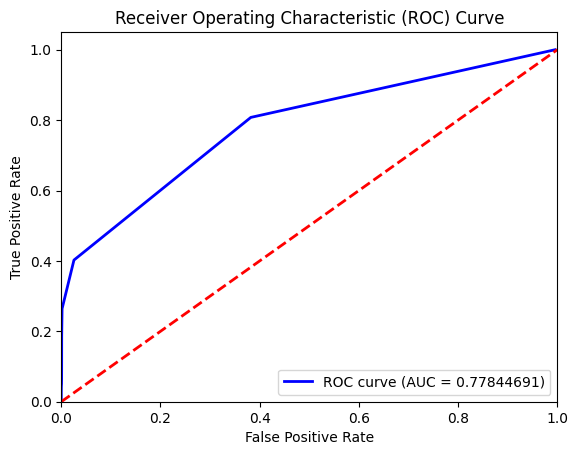

AUC Score: 0.7784469102372706
tp_test: 4852
tn_test: 689419
fp_test: 8921
fn_test: 19208


In [43]:
# Generate ROC curve
auc = abs(area_under_curve(fpr_list, tpr_list))
plt.plot(fpr_list, tpr_list, color='b', lw=2, label='ROC curve (AUC = %0.8f)' % auc)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC Score:", auc)

# Calculate metrics at target FPR
target_fpr = 0.05

  # Specify the desired false positive rate

fpr_array = np.array(fpr_list)
# Find the index closest to the target FPR
idx = np.abs(fpr_array - target_fpr).argmin()

# Calculate the corresponding metrics
tp_test = tp_list[idx]
tn_test = tn_list[idx]
fp_test = fp_list[idx]
fn_test = fn_list[idx]

for i in range(len(FINAL_LABELS_TEST)):
    if ATTACK_LABELS_TEST[i] == 0:
        if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
            tn_test += 1
        else:
            fp_test += 1
    else:
        if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
            tp_test += 1
        else:
            fn_test += 1



# Print the results
print("tp_test:", tp_test)
print("tn_test:", tn_test)
print("fp_test:", fp_test)
print("fn_test:", fn_test)

In [44]:
# Calculate additional metrics
accuracy = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test)
precision = tp_test / (tp_test + fp_test)
recall = tp_test / (tp_test + fn_test)
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.961061738648948
Precision: 0.35228345313294124
Recall: 0.20166251039068994
F1 Score: 0.25649565194407


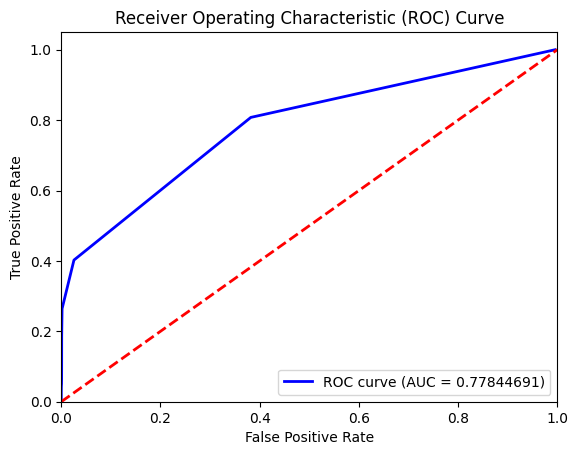

AUC Score: 0.7784469102372706
tp_test: 9728
tn_test: 564900
fp_test: 133440
fn_test: 14332


In [45]:
# Generate ROC curve
auc = abs(area_under_curve(fpr_list, tpr_list))
plt.plot(fpr_list, tpr_list, color='b', lw=2, label='ROC curve (AUC = %0.8f)' % auc)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC Score:", auc)

# Calculate metrics at target FPR
target_fpr = 0.3

  # Specify the desired false positive rate

fpr_array = np.array(fpr_list)
# Find the index closest to the target FPR
idx = np.abs(fpr_array - target_fpr).argmin()

# Calculate the corresponding metrics
tp_test = tp_list[idx]
tn_test = tn_list[idx]
fp_test = fp_list[idx]
fn_test = fn_list[idx]

for i in range(len(FINAL_LABELS_TEST)):
    if ATTACK_LABELS_TEST[i] == 0:
        if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
            tn_test += 1
        else:
            fp_test += 1
    else:
        if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
            tp_test += 1
        else:
            fn_test += 1



# Print the results
print("tp_test:", tp_test)
print("tn_test:", tn_test)
print("fp_test:", fp_test)
print("fn_test:", fn_test)

In [46]:
# Calculate additional metrics
accuracy = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test)
precision = tp_test / (tp_test + fp_test)
recall = tp_test / (tp_test + fn_test)
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.7954429678848284
Precision: 0.06794814483683505
Recall: 0.40432252701579385
F1 Score: 0.11634415289305619


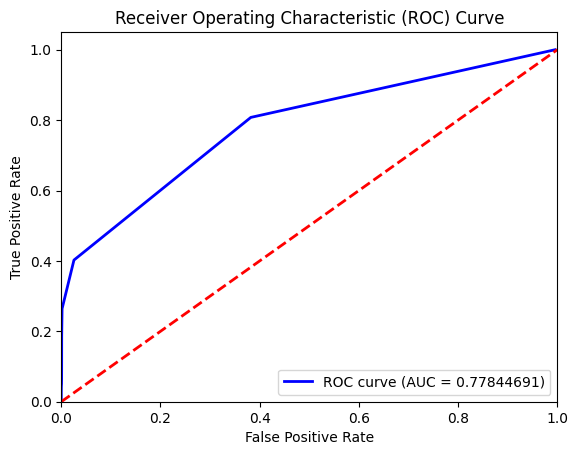

AUC Score: 0.7784469102372706
tp_test: 9728
tn_test: 564900
fp_test: 133440
fn_test: 14332


In [49]:
# Generate ROC curve
auc = abs(area_under_curve(fpr_list, tpr_list))
plt.plot(fpr_list, tpr_list, color='b', lw=2, label='ROC curve (AUC = %0.8f)' % auc)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC Score:", auc)

# Calculate metrics at target FPR
target_fpr = 0.4

  # Specify the desired false positive rate

fpr_array = np.array(fpr_list)
# Find the index closest to the target FPR
idx = np.abs(fpr_array - target_fpr).argmin()

# Calculate the corresponding metrics
tp_test = tp_list[idx]
tn_test = tn_list[idx]
fp_test = fp_list[idx]
fn_test = fn_list[idx]

for i in range(len(FINAL_LABELS_TEST)):
    if ATTACK_LABELS_TEST[i] == 0:
        if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
            tn_test += 1
        else:
            fp_test += 1
    else:
        if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
            tp_test += 1
        else:
            fn_test += 1



# Print the results
print("tp_test:", tp_test)
print("tn_test:", tn_test)
print("fp_test:", fp_test)
print("fn_test:", fn_test)

In [50]:
# Calculate additional metrics
accuracy = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test)
precision = tp_test / (tp_test + fp_test)
recall = tp_test / (tp_test + fn_test)
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.7954429678848284
Precision: 0.06794814483683505
Recall: 0.40432252701579385
F1 Score: 0.11634415289305619


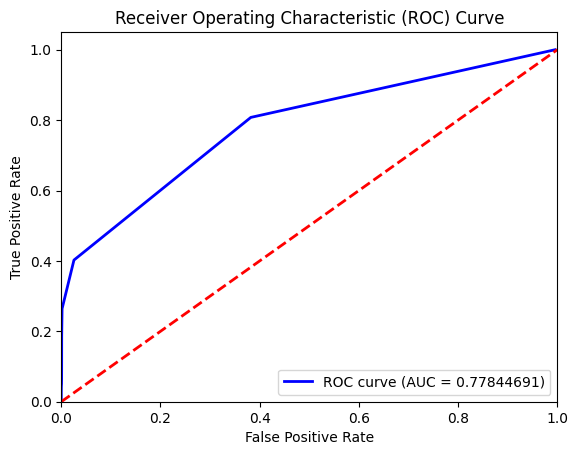

AUC Score: 0.7784469102372706
tp_test: 4852
tn_test: 689419
fp_test: 8921
fn_test: 19208


In [67]:
# Generate ROC curve
auc = abs(area_under_curve(fpr_list, tpr_list))
plt.plot(fpr_list, tpr_list, color='b', lw=2, label='ROC curve (AUC = %0.8f)' % auc)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC Score:", auc)

# Calculate metrics at target FPR
target_fpr = 0.1

  # Specify the desired false positive rate

fpr_array = np.array(fpr_list)
# Find the index closest to the target FPR
idx = np.abs(fpr_array - target_fpr).argmin()

# Calculate the corresponding metrics
tp_test = tp_list[idx]
tn_test = tn_list[idx]
fp_test = fp_list[idx]
fn_test = fn_list[idx]

for i in range(len(FINAL_LABELS_TEST)):
    if ATTACK_LABELS_TEST[i] == 0:
        if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
            tn_test += 1
        else:
            fp_test += 1
    else:
        if FINAL_LABELS_TEST[i] == ATTACK_LABELS_TEST[i]:
            tp_test += 1
        else:
            fn_test += 1



# Print the results
print("tp_test:", tp_test)
print("tn_test:", tn_test)
print("fp_test:", fp_test)
print("fn_test:", fn_test)

In [68]:
# Calculate additional metrics
accuracy = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test)
precision = tp_test / (tp_test + fp_test)
recall = tp_test / (tp_test + fn_test)
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.961061738648948
Precision: 0.35228345313294124
Recall: 0.20166251039068994
F1 Score: 0.25649565194407
